In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy

In [263]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D

## Build model architecture

In [15]:
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        if False:
            # first version I tried
            L.append( ZeroPadding2D((1, 1)) )
            L.append( Convolution2D(cdim, 3, 3, activation='relu', name=convname) )
        else:
            L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) )
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [280]:
def fcn32_blank():
    
    withDO = False # no effect during evaluation but usefull for fine-tuning
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        #mdl.add( Permute((1,2,3), input_shape=(3,224,224)) ) # WARNING : 0 is the sample dim
        mdl.add( Permute((1,2,3), input_shape=(3,512,512)) ) # WARNING : 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        mdl.add( Convolution2D(4096, 7, 7, border_mode='same', activation='relu', name='fc6') ) # WARNING border
        if withDO:
            mdl.add( Dropout(0.5) )
        mdl.add( Convolution2D(4096, 1, 1, border_mode='same', activation='relu', name='fc7') ) # WARNING border
        if withDO:
            mdl.add( Dropout(0.5) )
        # WARNING : model decapitation, remove the classifier step
        #mdl.add( Convolution2D(2622, 1, 1, name='fc8') )
        #mdl.add( Flatten() )
        #mdl.add( Activation('softmax') )
        
        mdl.add( Convolution2D(21, 1, 1,
                               border_mode='same', # WARNING : zero or same ? does not matter for 1x1
                               activation='relu', name='score_fr') )
        
        mdl.add( Deconvolution2D(21, 4, 4, # WARNING : exact meaning ?
                                 output_shape=(None, 21, 34, 34), # WARNING : exact meaning ?
                                 subsample=(2, 2), # WARNING : exact meaning ?
                                 border_mode='valid', # WARNING : valid, same or full ?
                                 activation=None,
                                 name = 'score2') )
        
        mdl.add( Cropping2D(cropping=((1, 1), (1, 1))) )
        #model.add(Cropping2D(cropping=((2, 2), (4, 4)), input_shape=(3, 28, 28)))
        # now model.output_shape == (None, 3, 24, 20)
        
        return mdl
    
    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [281]:
# WARNING : explanation about Deconvolution2D layer
# http://stackoverflow.com/questions/39018767/deconvolution2d-layer-in-keras
# the code example in the help (??Deconvolution2D) is very usefull too

#?? Deconvolution2D

In [282]:
fcn32model = fcn32_blank()

In [291]:
# WARNING : check dim weights against .mat file to check deconvolution setting
fcn32model.layers[-2].get_weights()[0].shape

(21, 21, 4, 4)

In [284]:
fcn32model.summary() # visual inspection of model architecture

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_25 (Permute)             (None, 3, 512, 512)   0           permute_input_25[0][0]           
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 512, 512)  1792        permute_25[0][0]                 
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 512, 512)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_121 (MaxPooling2D)  (None, 64, 256, 256)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

In [301]:
# to replicate MatConvNet.DAGN.Sum layer
# documentation : https://keras.io/getting-started/sequential-model-guide/
from keras.layers import merge

sp4 = Convolution2D(21, 1, 1,
                    border_mode='same', # WARNING : zero or same ? does not matter for 1x1
                    activation=None, # WARNING : to check
                    name='score_pool4')

# TEST CODE : merge([fcn32model.layers[-4].output, fcn32model.layers[-3].output], mode='sum')

summed = merge([sp4(fcn32model.layers[14].output), fcn32model.layers[-1].output], mode='sum')

# INFO : final 16x16 upsampling of "summed" using deconv layer upsample_new (32, 32, 21, 21)
upnew = Deconvolution2D(21, 32, 32, # WARNING : exact meaning ?
                        output_shape=(None, 21, 528, 528), # WARNING : exact meaning ?
                        border_mode='valid', # WARNING : valid, same or full ?
                        subsample=(16, 16),
                        activation=None,
                        name = 'upsample_new')

crop8 = Cropping2D(cropping=((8, 8), (8, 8)))

# WARNING : fcn16model is the model of interest
fcn16model = Model(fcn32model.input, crop8(upnew(summed)))
#fcn16model = Model(fcn32model.input, summed) # WARNING : debug code

In [302]:
# WARNING : check dim weights against .mat file to check deconvolution setting
upnew.get_weights()[0].shape

(21, 21, 32, 32)

In [303]:
fcn16model.summary() # visual inspection of model architecture

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_input_25 (InputLayer)    (None, 3, 512, 512)   0                                            
____________________________________________________________________________________________________
permute_25 (Permute)             (None, 3, 512, 512)   0           permute_input_25[0][0]           
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 512, 512)  1792        permute_25[0][0]                 
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 512, 512)  36928       conv1_1[0][0]                    
___________________________________________________________________________________________

## Load VGG weigths from .mat file

#### https://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation
##### Download from console with :
wget https://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat

In [7]:
from scipy.io import loadmat

In [8]:
if True:
    data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
else:
    raise ValueError('not implemented yet')
    data = loadmat('vgg_face_matconvnet/data/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
    net = data['net'][0,0]
    l = net.layers
    description = net.classes[0,0].description

In [9]:
l.shape, p.shape, description.shape

((1, 42), (1, 38), (1, 21))

In [164]:
#l[0,21].block[0,0], l[0,21].params
#print(l[0,36])
print(dir(l[0,36].block[0,0]))
lnb = 31 #36
#print(l[0,lnb].block[0,0].upsample)
#print(l[0,lnb].block[0,0].crop)
print(l[0,lnb].block[0,0].hasBias)
#print(l[0,lnb].block[0,0].numGroups)
print(l[0,lnb].block[0,0].size)
#print(l[0,lnb].block[0,0].opts)
print(l[0,lnb].block[0,0].pad)
print(l[0,lnb].block[0,0].stride)
print(l[0,lnb].block[0,0].dilate)

print('-------')
print(l[0,36].block[0,0].upsample, l[0,36].block[0,0].size, l[0,36].block[0,0].numGroups, l[0,36].block[0,0].crop)
print(l[0,40].block[0,0].upsample, )

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'crop', 'hasBias', 'numGroups', 'opts', 'size', 'upsample']
[[1]]
[[   7    7  512 4096]]
[[0 0 0 0]]
[[1 1]]
[[1 1]]
-------
(array([[2, 2]], dtype=uint8), array([[ 4,  4, 21, 21]], dtype=uint8), array([[1]], dtype=uint8), array([[0, 0, 0, 0]], dtype=uint8))
(array([[16, 16]], dtype=uint8),)


In [44]:
for i in range(0, p.shape[1]-1, 2):
    print(i, p[0,i].name[0], p[0,i].value.shape, p[0,i+1].name[0], p[0,i+1].value.shape)

(0, u'conv1_1_filter', (3, 3, 3, 64), u'conv1_1_bias', (64, 1))
(2, u'conv1_2_filter', (3, 3, 64, 64), u'conv1_2_bias', (64, 1))
(4, u'conv2_1_filter', (3, 3, 64, 128), u'conv2_1_bias', (128, 1))
(6, u'conv2_2_filter', (3, 3, 128, 128), u'conv2_2_bias', (128, 1))
(8, u'conv3_1_filter', (3, 3, 128, 256), u'conv3_1_bias', (256, 1))
(10, u'conv3_2_filter', (3, 3, 256, 256), u'conv3_2_bias', (256, 1))
(12, u'conv3_3_filter', (3, 3, 256, 256), u'conv3_3_bias', (256, 1))
(14, u'conv4_1_filter', (3, 3, 256, 512), u'conv4_1_bias', (512, 1))
(16, u'conv4_2_filter', (3, 3, 512, 512), u'conv4_2_bias', (512, 1))
(18, u'conv4_3_filter', (3, 3, 512, 512), u'conv4_3_bias', (512, 1))
(20, u'conv5_1_filter', (3, 3, 512, 512), u'conv5_1_bias', (512, 1))
(22, u'conv5_2_filter', (3, 3, 512, 512), u'conv5_2_bias', (512, 1))
(24, u'conv5_3_filter', (3, 3, 512, 512), u'conv5_3_bias', (512, 1))
(26, u'fc6_filter', (7, 7, 512, 4096), u'fc6_bias', (4096, 1))
(28, u'fc7_filter', (1, 1, 4096, 4096), u'fc7_bias', 

In [45]:
for i in range(l.shape[1]):
    print(i,
          str(l[0,i].name[0]), str(l[0,i].type[0]),
          [str(n[0]) for n in l[0,i].inputs[0,:]],
          [str(n[0]) for n in l[0,i].outputs[0,:]])

(0, 'conv1_1', 'dagnn.Conv', ['data'], ['conv1_1'])
(1, 'relu1_1', 'dagnn.ReLU', ['conv1_1'], ['conv1_1x'])
(2, 'conv1_2', 'dagnn.Conv', ['conv1_1x'], ['conv1_2'])
(3, 'relu1_2', 'dagnn.ReLU', ['conv1_2'], ['conv1_2x'])
(4, 'pool1', 'dagnn.Pooling', ['conv1_2x'], ['pool1'])
(5, 'conv2_1', 'dagnn.Conv', ['pool1'], ['conv2_1'])
(6, 'relu2_1', 'dagnn.ReLU', ['conv2_1'], ['conv2_1x'])
(7, 'conv2_2', 'dagnn.Conv', ['conv2_1x'], ['conv2_2'])
(8, 'relu2_2', 'dagnn.ReLU', ['conv2_2'], ['conv2_2x'])
(9, 'pool2', 'dagnn.Pooling', ['conv2_2x'], ['pool2'])
(10, 'conv3_1', 'dagnn.Conv', ['pool2'], ['conv3_1'])
(11, 'relu3_1', 'dagnn.ReLU', ['conv3_1'], ['conv3_1x'])
(12, 'conv3_2', 'dagnn.Conv', ['conv3_1x'], ['conv3_2'])
(13, 'relu3_2', 'dagnn.ReLU', ['conv3_2'], ['conv3_2x'])
(14, 'conv3_3', 'dagnn.Conv', ['conv3_2x'], ['conv3_3'])
(15, 'relu3_3', 'dagnn.ReLU', ['conv3_3'], ['conv3_3x'])
(16, 'pool3', 'dagnn.Pooling', ['conv3_3x'], ['pool3'])
(17, 'conv4_1', 'dagnn.Conv', ['pool3'], ['conv4_1'])


In [82]:
# documentation for the dagnn.Crop layer :
# https://github.com/vlfeat/matconvnet/blob/master/matlab/%2Bdagnn/Crop.m

### Fully Convolutional Networks for Semantic Segmentation
##### Jonathan Long, Evan Shelhamer, Trevor Darrell

www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf

Extract from the article relating to the model architecture.

The model is derived from VGG16.

**remark** : deconvolution and conv-transpose are synonyms, they perform up-sampling

#### 4.1. From classifier to dense FCN

We decapitate each net by discarding the final classifier layer [**code comment** : *this is why fc8 is not included*], and convert all fully connected layers to convolutions.

We append a 1x1 convolution with channel dimension 21 [**code comment** : *layer named score_fr*] to predict scores for each of the PASCAL classes (including background) at each of the coarse output locations, followed by a deconvolution layer to bilinearly upsample the coarse outputs to pixel-dense outputs as described in Section 3.3.


#### 4.2. Combining what and where
We define a new fully convolutional net (FCN) for segmentation that combines layers of the feature hierarchy and
refines the spatial precision of the output.
While fully convolutionalized classifiers can be fine-tuned to segmentation as shown in 4.1, and even score highly on the standard metric, their output is dissatisfyingly coarse.
The 32 pixel stride at the final prediction layer limits the scale of detail in the upsampled output.

We address this by adding skips that combine the final prediction layer with lower layers with finer strides.
This turns a line topology into a DAG [**code comment** : *this is why some latter stage layers have 2 inputs*], with edges that skip ahead from lower layers to higher ones.
As they see fewer pixels, the finer scale predictions should need fewer layers, so it makes sense to make them from shallower net outputs.
Combining fine layers and coarse layers lets the model make local predictions that respect global structure.

We first divide the output stride in half by predicting from a 16 pixel stride layer.
We add a 1x1 convolution layer on top of pool4 [**code comment** : *the score_pool4_filter layer*] to produce additional class predictions.
We fuse this output with the predictions computed on top of conv7 (convolutionalized fc7) at stride 32 by adding a 2x upsampling layer and summing [**code comment** : *layer named sum*] both predictions [**code warning** : *requires first layer crop to insure the same size*].

Finally, the stride 16 predictions are upsampled back to the image [**code comment** : *layer named upsample_new*].

We call this net FCN-16s.

In [136]:
# TODO : adapt this function
def weight_compare(kmodel):
    
    raise ValueError('not implemented yet')
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (3,2,0,1) # WARNING : important setting as 2 of the 4 axis have same size dimension

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print matname, mattype
            print l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape
            print kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape
            print '------------------------------------------'
        else:
            print 'MISSING : ', matname, mattype
            print '------------------------------------------'

In [137]:
#weight_compare(fcn32model)
#weight_compare(fcn16model)

In [138]:
# TODO : adapt this function
def copy_mat_to_keras(kmodel):
    
    raise ValueError('not implemented yet')

    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (3,2,0,1) # WARNING : important setting as 2 of the 4 axis have same size dimension

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print matname
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            f_l_weights = np.flip(f_l_weights, 2)
            f_l_weights = np.flip(f_l_weights, 3)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
            #print '------------------------------------------'

In [269]:
im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.resize((512,512))

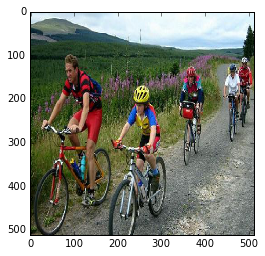

In [270]:
plt.imshow(np.asarray(im))

In [148]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    imarr = imarr.transpose((2,0,1))
    imarr = np.expand_dims(imarr, axis=0)

    out = kmodel.predict(imarr)

    #best_index = np.argmax(out, axis=1)[0]
    #best_name = description[best_index,0]
    #print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])
    
    return out

In [306]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit

#testmodel = Model(fcn32model.input, fcn32model.layers[-2].output) # works OK
dec = Deconvolution2D(21, 4, 4, # WARNING : exact meaning ?
                      output_shape=(None, 21, 34, 34), # WARNING : exact meaning ?
                      border_mode='valid', # WARNING : zero or same ?
                      subsample=(2, 2), # WARNING : exact meaning ?
                      activation=None)
#testmodel = Model(fcn32model.input, dec(fcn32model.layers[-3].output))
#testmodel = fcn32model # works OK
testmodel = fcn16model

In [307]:
pred(testmodel, crpim, transform=False).shape

(1, 21, 512, 512)

In [308]:
# code sample from help "??Deconvolution2D"
if True:
        # apply a 3x3 transposed convolution
        # with stride 1x1 and 3 output filters on a 12x12 image:
        model = Sequential()
        model.add(Deconvolution2D(21, 4, 4, output_shape=(None, 21, 19, 19),
                                  border_mode='valid',
                                  input_shape=(21, 16, 16)))
        # Note that you will have to change
        # the output_shape depending on the backend used.

        # we can predict with the model and print the shape of the array.
        dummy_input = np.ones((1, 21, 16, 16))
        # For TensorFlow dummy_input = np.ones((1, 12, 12, 3))
        preds = model.predict(dummy_input)
        print(preds.shape)
        # Theano GPU: (None, 3, 13, 13)
        # Theano CPU: (None, 3, 14, 14)
        # TensorFlow: (None, 14, 14, 3)

        # apply a 3x3 transposed convolution
        # with stride 2x2 and 3 output filters on a 12x12 image:
        model = Sequential()
        model.add(Deconvolution2D(21, 4, 4, output_shape=(None, 21, 34, 34),
                                  subsample=(2, 2),
                                  border_mode='valid',
                                  input_shape=(21, 16, 16)))
        model.summary()

        # we can predict with the model and print the shape of the array.
        dummy_input = np.ones((1, 21, 16, 16))
        # For TensorFlow dummy_input = np.ones((1, 12, 12, 3))
        preds = model.predict(dummy_input)
        print(preds.shape)
        # Theano GPU: (None, 3, 25, 25)
        # Theano CPU: (None, 3, 25, 25)
        # TensorFlow: (None, 25, 25, 3)

(1, 21, 19, 19)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
deconvolution2d_46 (Deconvolutio (None, 21, 34, 34)    7077        deconvolution2d_input_32[0][0]   
Total params: 7,077
Trainable params: 7,077
Non-trainable params: 0
____________________________________________________________________________________________________
(1, 21, 34, 34)
